In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import shapely.geometry
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
# import dask

# import personal modules
# Path to modules
sys.path.append('../../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import load_trajectories
# dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/' 
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures

In [3]:
# import configuration file for case study choice
yaml_doc = '../../data/domains.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)

In [4]:
def get_landfall_locs(ds, start_mon, end_mon):
    ## subset to months
    ds = select_months_ds(ds, start_mon, end_mon, 'start_date')
    df_lst = []
    for i, HUC8 in enumerate(ds.HUC8.values):
    
        tmp = ds.sel(HUC8=HUC8)
        tmp = tmp.where(tmp['ar_scale'] > 0, drop=True)
        time_match = tmp.time_match.values
        lat_match = tmp.lat_match.values
        lon_match = tmp.lon_match.values
        start_date = tmp.start_date.values
        
        d = {'landfall_time': time_match, 'lat': lat_match, 'lon': lon_match, 
             'HUC8': tmp.HUC8.values, 'start_date': start_date}
        df = pd.DataFrame(d)
        df_lst.append(df)
    
    df = pd.concat(df_lst)
    df2 = df.pivot_table(index = ['lat', 'lon'], aggfunc ='size')
    df2
    df2 = df2.reset_index()
    colname = df2.columns[-1]
    
    return colname, df2

In [5]:
## load trajectories
ds = load_trajectories('combined_extreme_AR')

colname1, df1 = get_landfall_locs(ds, 11, 4)
colname2, df2 = get_landfall_locs(ds, 5, 10)

In [6]:
# ## halfway time
# def halfway_time(row):

#     time1 = pd.to_datetime(row['start_date'])
#     time2 = pd.to_datetime(row['landfall_time'])

#     return time1 + (time2 - time1) / 2
    
# # Apply the user-defined function to every row
# df['halfway_time'] = df.apply(halfway_time, axis=1)
# df

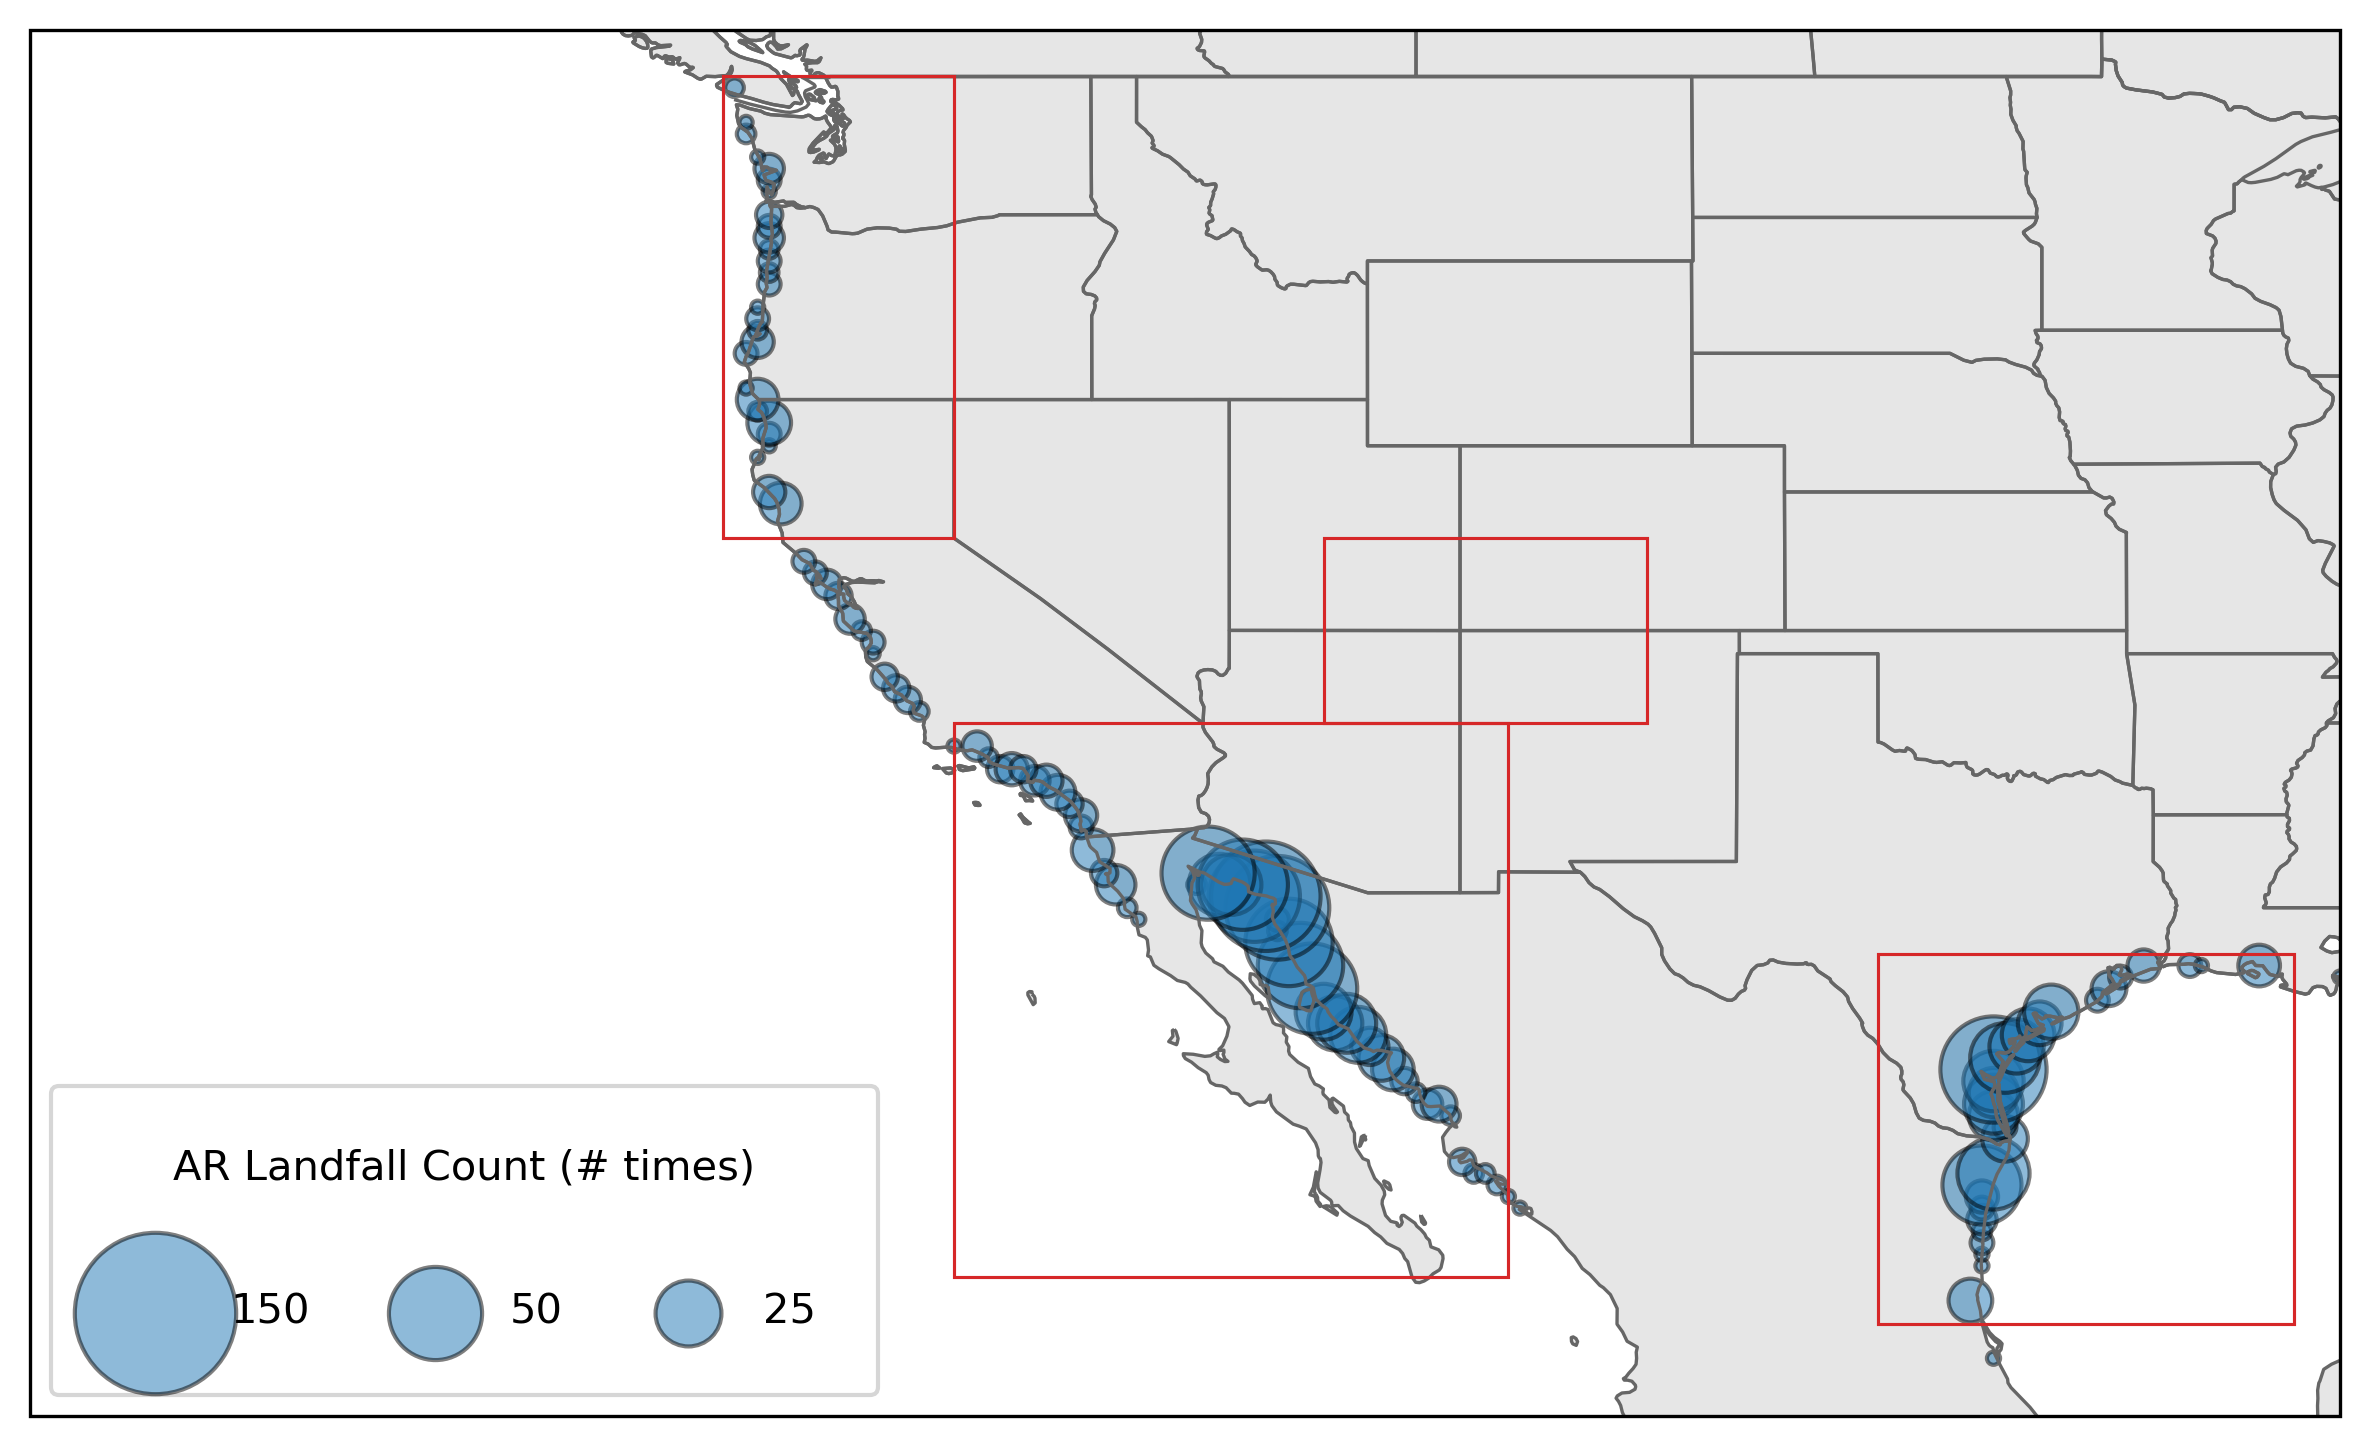

In [7]:
fname = path_to_figs + 'ar-landfall_freq'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.,6.))
fig.dpi = 300

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext = [-140., -90., 20, 50]
xticks = np.arange(ext[0],ext[1]+5,5)
yticks = np.arange(ext[2],ext[3]+5,5)
    
ax = plt.axes(projection=mapcrs)
ax.set_extent(ext, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## Add ERA-Interim Gridlines and Labels
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(yticks)
gl.ylocator = mticker.FixedLocator(xticks)
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Bubbles
x = df2.lon.values
y = df2.lat.values
z = df2[colname2].values
scl = 10
sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')
# new = ax.scatter(lons_add, lats_add, s=250, c='tab:red', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')

# legend
msizes = [150*scl, 50*scl, 25*scl]
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

ax.legend(handles=markers, loc='lower left', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (# times)', ncol=3)

## add extent of bbox
region_lst = ['baja', 'san_juan', 'gulf_of_mexico', 'pnw']
for i, region in enumerate(region_lst):
    ext3 = config[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='tab:red',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))


# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()